# Imports

In [1]:
import anonymisation as anno
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.patches as patches
import sys
import os
import itertools
import numpy as np
from sdv.datasets.local import load_csvs
from sdv.metadata import MultiTableMetadata
from sdv.metadata import SingleTableMetadata
from sdv.multi_table import HMASynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from faker import Faker
import datetime
from itertools import combinations

# Synthesize

In [2]:
def synthesizeData(directory: str, data_set: str, single_table = True) -> pd.DataFrame:
    """
This function creates new set of data from the dataset and returns a dataframe containing the new data.

Function: synthesizeData
Args:  
  Mandatory
    directory (str):    Directory containing the dataset.
    data_set (str):     Dataset used for synthetication.
Returns:
    pd.DataFrame:       Newly synthesized data.
"""
    # Load the data.
    data = load_csvs(folder_name = directory)
    bodyPerformance = data[data_set]
    if single_table:
        # Prepare the data for synthetication.
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(bodyPerformance)
        metadata.validate()
        
        # Synthesize the data.
        synthesizer = GaussianCopulaSynthesizer(metadata)
        synthesizer.fit(bodyPerformance)
        synthetic_data = synthesizer.sample(num_rows=10000)
    else:
        # Prepare the data for synthetication.
        metadata = MultiTableMetadata()
        metadata.detect_from_dataframes(data)
        metadata.detect_from_dataframe(bodyPerformance)
        metadata.validate()
        
        # Synthesize the data.
        synthesizer = HMASynthesizer(metadata)
        synthesizer.fit(bodyPerformance)
        synthetic_data = synthesizer.sample(scale=1)

    metadata.save_to_json(filepath='./my_metadata_v1.json')

    return synthetic_data

In [3]:
def generateProfile(gender: str, age: str ) -> dict:
    """
This function creates new set of personal information.

Function: generateProfile
Args:  
  Mandatory
    gender (str):    Defines the set of names that is generated.
    age (str):       Used to ensure the correlation between age and performance.
Returns:
    dict:            Dictionary containing generated personal information.
"""
    # Generate basic information.
    fake = Faker()
    profiles = [fake.profile(sex=gen) for gen in gender]
    phones = [fake.phone_number() for _ in gender]
    emails = [profile['mail'] for profile in profiles]

    # Generate spatia information.
    addresses = [profile['address'].split('\n') for profile in profiles]
    cities = [address[1].split(',')[0] for address in addresses]
    states = [address[1].split(',')[1] if len(address[1].split(',')) > 1 else '-' for address in addresses]

    # Generate birthday.
    toDate = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')
    today = datetime.date.today()
    years =  [today - datetime.timedelta(days = year * 365) for year in age]
    years = [year.year for year in years]
    birthdates = [fake.date_between(start_date = toDate(f"{year}-01-01"), end_date = toDate(f"{year}-12-31")) for year in years]

    # Fix phonenumbers.
    phone_numbers = [phone.split('x')[0].replace('.', '-') for phone in phones]

    return {
        'name': [profile['name'] for profile in profiles],
        'address': [address[0] for address in addresses],
        'city': cities,
        'state': states,
        'email': emails,
        'birthdate': [birthdate for birthdate in birthdates],
        'phone#': phone_numbers
    }

In [4]:
def createFakePII(data: pd.DataFrame) -> pd.DataFrame:
    """
This function creates new set of data from the dataset and returns a dataframe containing the new data.

Function: synthesizeData
Args:  
  Mandatory
    data (pd.DataFrame):     Dataframe used for creating personal information.
Returns:
    pd.DataFrame             Dataframe containing the data from given dataframe and generated personal information.
"""
    # Generate personal information.
    result = generateProfile(data['gender'], data['age'])
    pii_date = pd.DataFrame(result)
    # Combine the old dataframe with the personal information.
    new_df = pd.concat([data, pii_date], axis = 1)
    new_df = new_df.drop(['age'], axis = 1)
    return new_df

In [5]:
if False:
    synth_data = synthesizeData('./', 'bodyPerformance')
    new_df = createFakePII(synth_data)
    new_df.to_csv('./synthetic_data.csv', index = False)

# Anonymise

## Datan käsittely

In [6]:
categorical = ['gender', 'class', 'city', 'state']
# Features that are aggragated.
feature_columns = ['state', 'age', 'gender']
# Sensitive features.
sensitive_column = ['height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm']
# Remove idenfitiable columns
drop_columns = ['name', 'address', 'email', 'phone#', 'birthdate', 'city']
df_origin = pd.read_csv('./synthetic_data.csv')
# Fix column type.
for name in categorical:
    df_origin[name] = df_origin[name].astype('category')
df = df_origin.copy(deep = True)

In [7]:
df_origin

,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,name,address,city,state,email,birthdate,phone#
0,F,162.4,68.26,27.922190,81.3,122.2,21.95,6.05,18.1,140.3,B,Amanda Mcdonald,"PSC 1587, Box 9663",APO AE 84422,-,castronoah@yahoo.com,1990-07-17,245-801-2336
1,F,158.9,61.89,28.554614,81.3,122.8,33.18,21.19,39.4,139.0,C,Melinda Solomon,45576 Nathan Center Apt. 555,Brandonmouth,GA 80704,drewlarsen@hotmail.com,1992-06-15,6722039702
2,F,149.8,53.12,37.959081,75.9,132.7,16.27,26.23,12.0,131.0,A,Carla Drake,540 Ramirez Brooks,Kellychester,VA 94190,george06@hotmail.com,1980-01-13,(510)435-8045
3,M,181.0,80.61,20.102330,65.1,112.8,45.23,21.61,39.0,227.3,B,Dennis Phillips,94050 Ariana Tunnel Suite 394,Lake Kara,CT 24442,chungsandra@hotmail.com,1994-03-02,+1-304-939-9091
4,M,173.8,78.56,17.483814,81.5,122.0,46.55,12.35,42.1,191.7,A,Matthew Hendrix,3055 Edwin Crossing Suite 339,Jenniferfurt,MS 99344,lisapena@gmail.com,1991-10-12,001-742-253-6406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M,166.7,57.84,16.666282,90.2,175.5,31.28,24.17,51.2,194.8,A,Stephen Woods,006 Ana Unions,Jessicatown,MT 69100,guerragabriella@hotmail.com,1996-07-12,762-622-7138
9996,M,183.3,72.24,10.671413,74.6,118.5,55.19,10.41,52.6,266.5,A,Ralph Pena,60484 Fox Corner Suite 126,Bradychester,WY 20414,cconner@yahoo.com,1981-01-04,973-633-8011
9997,M,160.6,55.57,29.365750,88.8,118.9,23.09,0.21,26.0,136.2,D,James Aguirre,54003 Christine Island,Vanceville,FL 93529,jeffrey52@gmail.com,2000-03-23,963-334-0744
9998,F,162.0,50.49,15.098607,66.9,111.7,32.98,19.20,32.0,186.6,A,Elizabeth Snyder,4340 Kemp Mountain Apt. 653,Stevenside,MN 85760,katrinacruz@hotmail.com,1983-08-30,828-954-9334


In [9]:
# Fixing columns.
df['birthdate'] = pd.to_datetime(df['birthdate'], format = '%Y-%m-%d')
# Generelize birthday to age..
df['age'] = datetime.datetime.today().year - df['birthdate'].dt.year
df = df.drop(drop_columns, axis = 1)
# Fix column type.
df.iloc[:, 2:-3] = df.iloc[:, 2:-3].astype(int) 
df.name = 'origin'

In [10]:
df

,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,state,age
0,F,162.4,68.0,27.0,81.0,122.0,21.0,6.0,18.0,140.0,B,-,34
1,F,158.9,61.0,28.0,81.0,122.0,33.0,21.0,39.0,139.0,C,GA 80704,32
2,F,149.8,53.0,37.0,75.0,132.0,16.0,26.0,12.0,131.0,A,VA 94190,44
3,M,181.0,80.0,20.0,65.0,112.0,45.0,21.0,39.0,227.0,B,CT 24442,30
4,M,173.8,78.0,17.0,81.0,122.0,46.0,12.0,42.0,191.0,A,MS 99344,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M,166.7,57.0,16.0,90.0,175.0,31.0,24.0,51.0,194.0,A,MT 69100,28
9996,M,183.3,72.0,10.0,74.0,118.0,55.0,10.0,52.0,266.0,A,WY 20414,43
9997,M,160.6,55.0,29.0,88.0,118.0,23.0,0.0,26.0,136.0,D,FL 93529,24
9998,F,162.0,50.0,15.0,66.0,111.0,32.0,19.0,32.0,186.0,A,MN 85760,41


In [11]:
# This function calculates the span for each column and returns a dictionary containing them.
full_span = anno.getSpans(df, df.index)

In [12]:
# This function relabels the categorical columns for visualization.
indexes = anno.buildIndexes(df)

## K-anonymisointi

In [13]:
# This function divides the dataframe to smaller partitions and returns a list containing them.
finished = anno.partitionDatasetMulti(df, feature_columns, sensitive_column, full_span, anno.isKAnonymous)

In [14]:
# This function creates anonymized dataframe and returns it.
df_k_anom = anno.buildAnonymizedDatasetMulti(df, finished, feature_columns, sensitive_column)

Finished 1 partitions..
Finished 101 partitions..
Finished 201 partitions..
Finished 301 partitions..
Finished 401 partitions..
Finished 501 partitions..
Finished 601 partitions..
Finished 701 partitions..
Finished 801 partitions..
Finished 901 partitions..
Finished 1001 partitions..
Finished 1101 partitions..
Finished 1201 partitions..
Finished 1301 partitions..
Finished 1401 partitions..
Finished 1501 partitions..
Finished 1601 partitions..
Finished 1701 partitions..
Finished 1801 partitions..
Finished 1901 partitions..
Finished 2001 partitions..
Finished 2101 partitions..
Finished 2201 partitions..
Finished 2301 partitions..
Finished 2401 partitions..


In [15]:
df_k_anom

,state,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,154.2,58.0,37.0,66.0,127.0,23.0,19.0,5.0,75.0
1,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,156.5,50.0,28.0,78.0,124.0,27.0,15.0,28.0,137.0
2,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,157.4,58.0,19.0,85.0,126.0,24.0,33.0,48.0,223.0
3,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,157.8,52.0,23.0,78.0,128.0,28.0,13.0,38.0,152.0
4,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,163.1,53.0,33.0,82.0,117.0,31.0,23.0,20.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2,"SC 82773, CA 66289, SC 49728",58.0,M,174.4,87.0,26.0,101.0,157.0,46.0,12.0,34.0,189.0
0,"MN 46144, NV 84394, TN 28164, NE 54436",58.0,M,158.4,55.0,28.0,74.0,116.0,13.0,24.0,35.0,145.0
1,"MN 46144, NV 84394, TN 28164, NE 54436",58.0,M,175.3,66.0,16.0,79.0,111.0,52.0,11.0,19.0,203.0
2,"MN 46144, NV 84394, TN 28164, NE 54436",58.0,M,178.4,73.0,12.0,82.0,143.0,43.0,25.0,46.0,212.0


In [16]:
# This function calculates the rectangles coordinates for plotting and returns a list containing all of the rectangles.
rects = anno.getPartitionRects(df, finished, feature_columns[0], feature_columns[1], indexes, offsets = [0.0, 0.0])

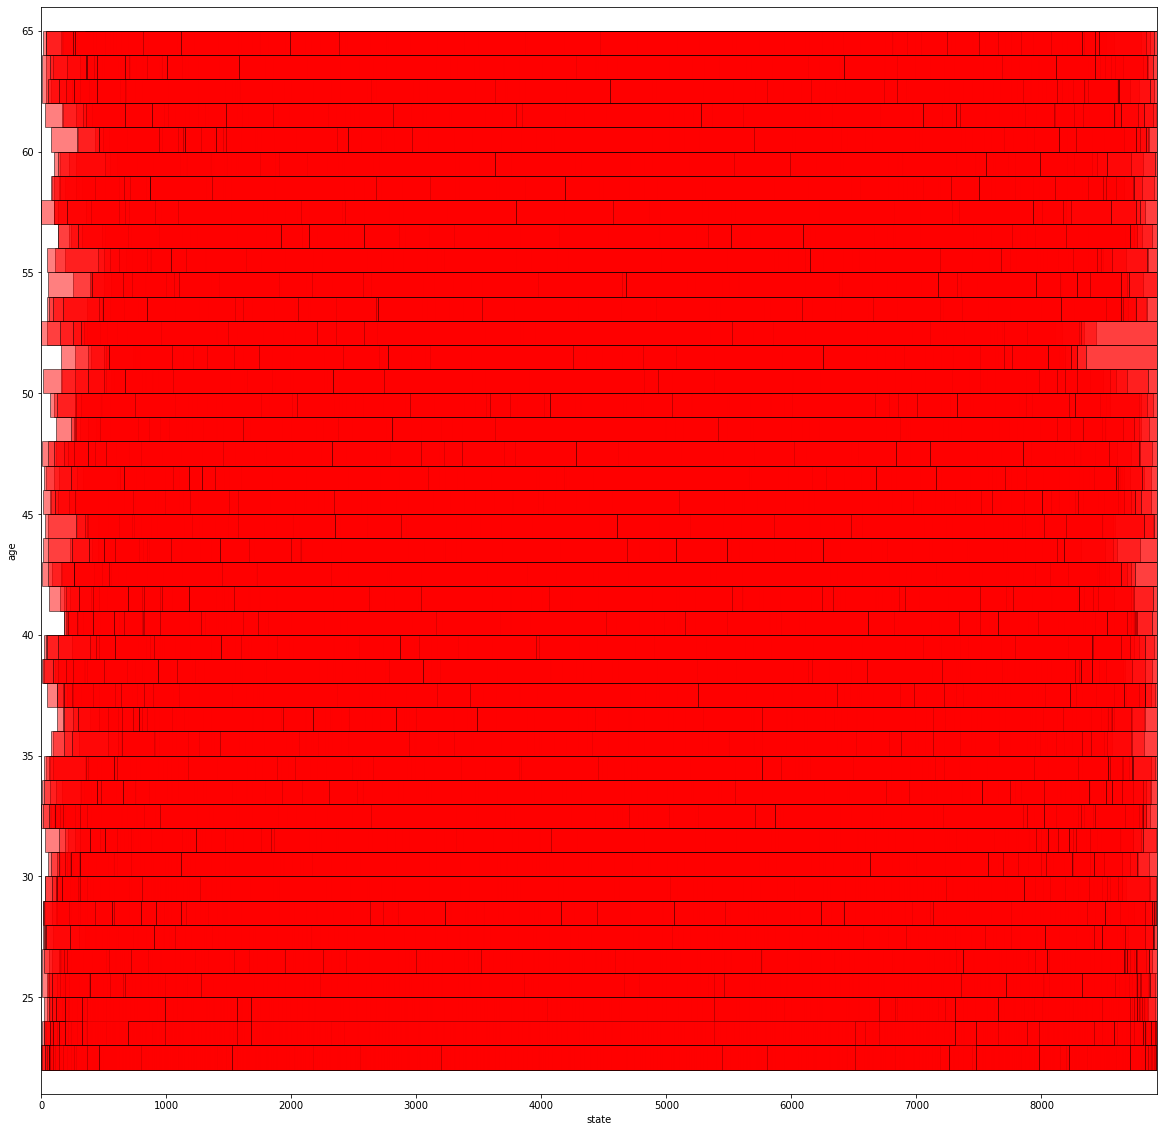

In [17]:
plt.figure(figsize = (20,20))
ax = plt.subplot(111)
# This function plots rectangles that represent the anonymised data, where each rectangle is an anonymised sub group.
anno.plotRects(df, ax, rects, feature_columns[0], feature_columns[1], indexes, facecolor = 'r')
#plt.scatter(df[feature_columns[0]], df[feature_columns[1]])
plt.show()

## L-diversiteetti

In [18]:
# This function divides the dataframe to smaller partitions and returns a list containing them.
finished_l = anno.partitionDatasetMulti(df, feature_columns, sensitive_column, full_span, lambda *args: anno.isKAnonymous(*args) and anno.isLDiverseMulti(*args))

In [19]:
# This function calculates the rectangles coordinates for plotting and returns a list containing all of the rectangles.
l_diverse_rects = anno.getPartitionRects(df, finished_l, feature_columns[0], feature_columns[1], indexes, offsets = [0.0, 0.0])

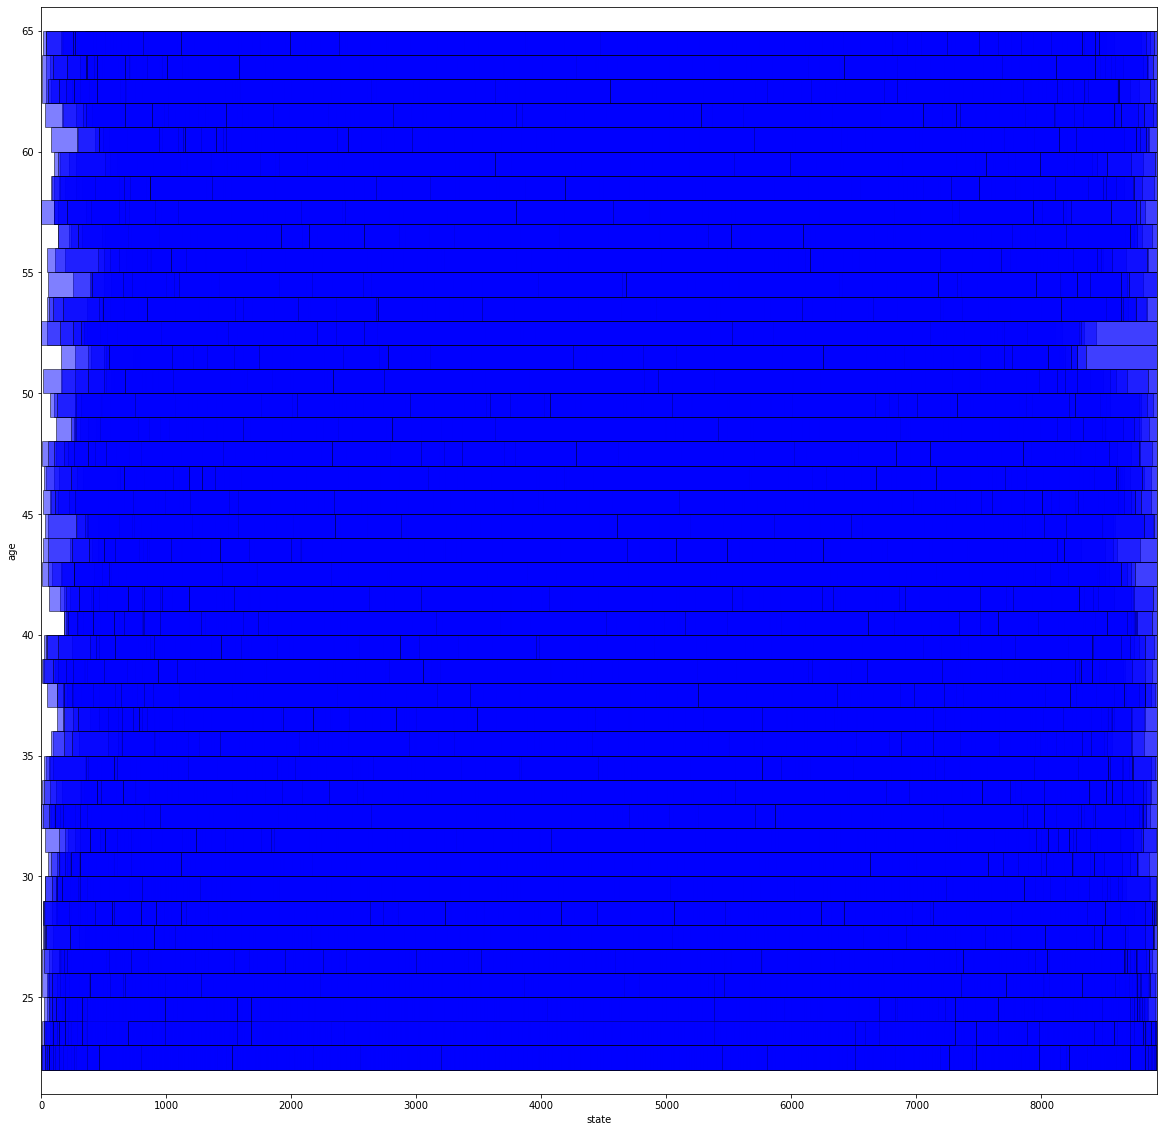

In [20]:
plt.figure(figsize = (20,20))
ax = plt.subplot(111)
# This function plots rectangles that represent the anonymised data, where each rectangle is an anonymised sub group.
anno.plotRects(df, ax, l_diverse_rects, feature_columns[0], feature_columns[1], indexes, facecolor = 'b')
#plotRects(df, ax, rects, feature_columns[0], feature_columns[1], facecolor = 'r')
#plt.scatter(df[featur_columns[0]], df[featur_columns[1]])
plt.show()

In [21]:
# This function creates anonymized dataframe and returns it.
df_l_div = anno.buildAnonymizedDatasetMulti(df, finished_l, feature_columns, sensitive_column)

Finished 1 partitions..
Finished 101 partitions..
Finished 201 partitions..
Finished 301 partitions..
Finished 401 partitions..
Finished 501 partitions..
Finished 601 partitions..
Finished 701 partitions..
Finished 801 partitions..
Finished 901 partitions..
Finished 1001 partitions..
Finished 1101 partitions..
Finished 1201 partitions..
Finished 1301 partitions..
Finished 1401 partitions..
Finished 1501 partitions..
Finished 1601 partitions..
Finished 1701 partitions..
Finished 1801 partitions..
Finished 1901 partitions..
Finished 2001 partitions..
Finished 2101 partitions..
Finished 2201 partitions..
Finished 2301 partitions..
Finished 2401 partitions..


In [22]:
df_l_div

,state,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,154.2,58.0,37.0,66.0,127.0,23.0,19.0,5.0,75.0
1,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,156.5,50.0,28.0,78.0,124.0,27.0,15.0,28.0,137.0
2,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,157.4,58.0,19.0,85.0,126.0,24.0,33.0,48.0,223.0
3,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,157.8,52.0,23.0,78.0,128.0,28.0,13.0,38.0,152.0
4,"NM 54971, AL 67778,-, PR 53480, WY 72337",49.0,F,163.1,53.0,33.0,82.0,117.0,31.0,23.0,20.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2,"SC 82773, CA 66289, SC 49728",58.0,M,174.4,87.0,26.0,101.0,157.0,46.0,12.0,34.0,189.0
0,"MN 46144, NV 84394, TN 28164, NE 54436",58.0,M,158.4,55.0,28.0,74.0,116.0,13.0,24.0,35.0,145.0
1,"MN 46144, NV 84394, TN 28164, NE 54436",58.0,M,175.3,66.0,16.0,79.0,111.0,52.0,11.0,19.0,203.0
2,"MN 46144, NV 84394, TN 28164, NE 54436",58.0,M,178.4,73.0,12.0,82.0,143.0,43.0,25.0,46.0,212.0


## T-läheisyys

In [23]:
# Get the distribution of the unique values in the data.
global_freqs = {column: df[column].value_counts() / df.shape[0] for column in sensitive_column}

In [24]:
# This function divides the dataframe to smaller partitions and returns a list containing them.
finished_t = anno.partitionDatasetMulti(df, feature_columns, sensitive_column, full_span, lambda *args: anno.isKAnonymous(*args) and anno.isLDiverseMulti(*args, 5).all() and anno.isTCloseMulti(*args, global_freqs, 0.1))

In [25]:
# This function creates anonymized dataframe and returns it.
df_t_close = anno.buildAnonymizedDatasetMulti(df, finished_t, feature_columns, sensitive_column)

Finished 1 partitions..


In [26]:
df_t_close.name = 'anom'

In [27]:
# This function calculates the rectangles coordinates for plotting and returns a list containing all of the rectangles.
t_close_rects = anno.getPartitionRects(df, finished_t, feature_columns[0], feature_columns[1], indexes, offsets = [0.0, 0.0])

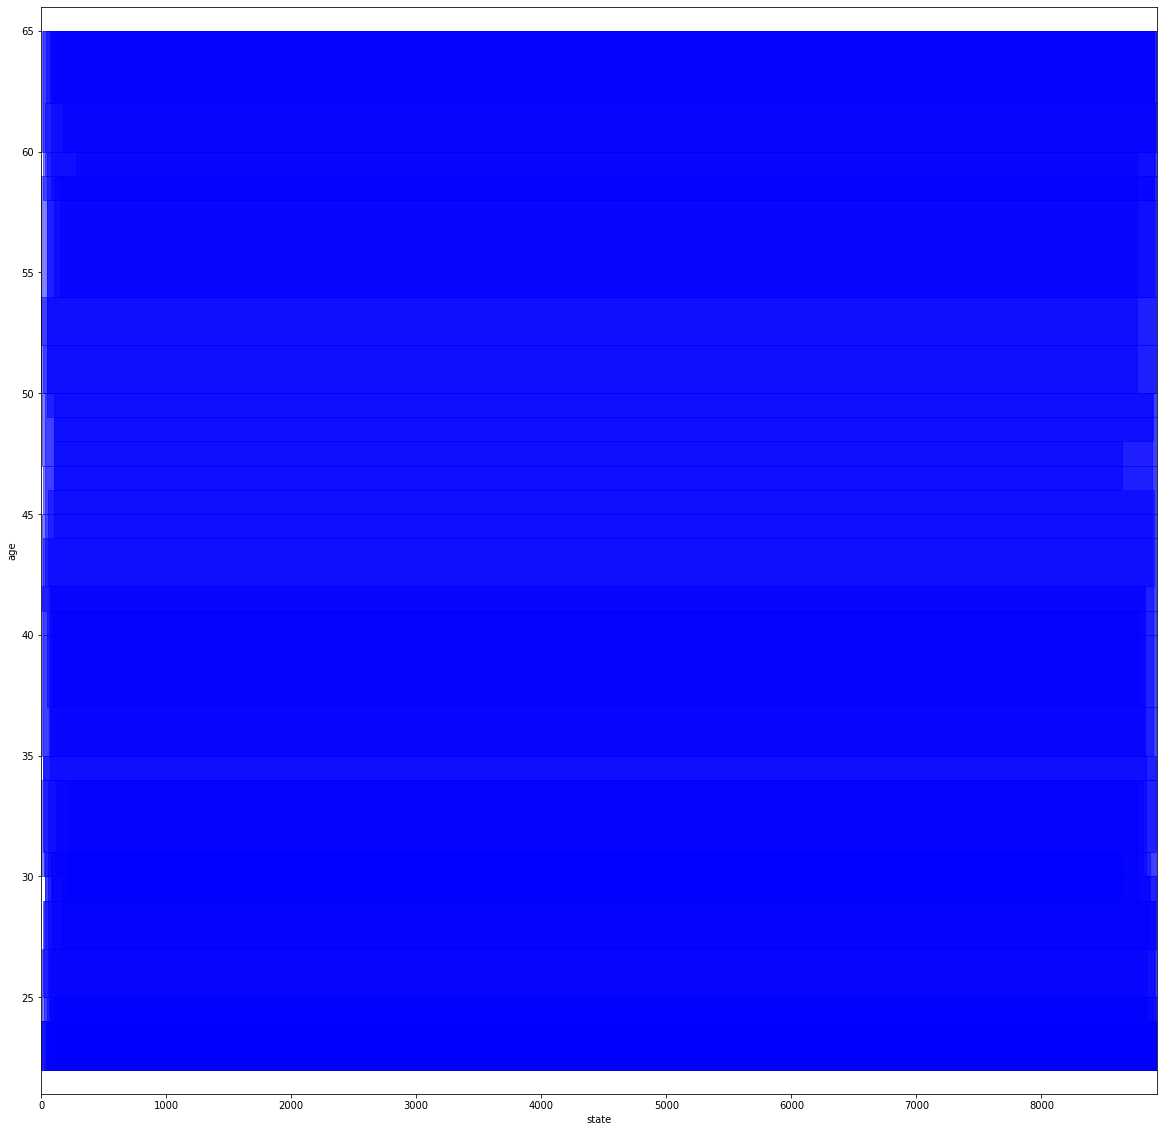

In [28]:
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
# This function plots rectangles that represent the anonymised data, where each rectangle is an anonymised sub group.
anno.plotRects(df, ax, t_close_rects, feature_columns[0], feature_columns[1], indexes, edgecolor = 'b', facecolor = 'b')
#plt.scatter(df[feature_columns[0]], df[feature_columns[1]])
plt.show()

### Add size of the sub group

In [29]:
df_t_close = df_t_close.reset_index(drop = True)

In [30]:
temp = df_t_close.groupby(['gender', 'state', 'age']).size().reset_index().rename(columns={0: 'count'})
df_t_close = df_t_close.merge(temp, how = 'left', on = ['state', 'gender', 'age'])

In [31]:
df_t_close

,state,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,count
0,"RI 03216, OR 45832, MN 21517, IA 63640, OK 34...",23.43038,F,144.8,57.0,46.0,80.0,114.0,13.0,25.0,26.0,120.0,237
1,"RI 03216, OR 45832, MN 21517, IA 63640, OK 34...",23.43038,F,147.5,51.0,36.0,81.0,125.0,15.0,23.0,17.0,105.0,237
2,"RI 03216, OR 45832, MN 21517, IA 63640, OK 34...",23.43038,F,148.2,57.0,42.0,69.0,125.0,15.0,25.0,22.0,147.0,237
3,"RI 03216, OR 45832, MN 21517, IA 63640, OK 34...",23.43038,F,148.6,40.0,31.0,72.0,112.0,13.0,15.0,36.0,173.0,237
4,"RI 03216, OR 45832, MN 21517, IA 63640, OK 34...",23.43038,F,148.7,53.0,35.0,86.0,130.0,24.0,11.0,4.0,110.0,237
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"AZ 22049, HI 44835, MS 79364, AS 03810, SD 90...",48.504673,M,181.3,76.0,23.0,91.0,152.0,35.0,20.0,50.0,209.0,107
9996,"AZ 22049, HI 44835, MS 79364, AS 03810, SD 90...",48.504673,M,182.5,74.0,16.0,91.0,155.0,49.0,16.0,57.0,204.0,107
9997,"AZ 22049, HI 44835, MS 79364, AS 03810, SD 90...",48.504673,M,182.5,80.0,19.0,74.0,134.0,51.0,26.0,57.0,237.0,107
9998,"AZ 22049, HI 44835, MS 79364, AS 03810, SD 90...",48.504673,M,182.7,85.0,15.0,70.0,107.0,53.0,10.0,60.0,266.0,107


### Check the distribution of the feature columns

In [32]:
df_t_close['age'].value_counts()

age
22.42401960784314     408
24.86104218362283     403
54.07242339832869     359
22.363636363636363    275
26.442379182156134    269
52.89453125           256
32.45606694560669     239
23.430379746835442    237
36.6                  235
22.0                  226
63.58447488584475     219
42.41203703703704     216
62.592233009708735    206
34.94634146341463     205
54.71568627450981     204
45.377450980392155    204
37.78350515463917     194
24.833333333333332    192
26.395604395604394    182
26.63736263736264     182
38.146067415730336    178
38.01685393258427     178
31.588571428571427    175
43.61494252873563     174
63.70348837209303     172
22.619883040935672    171
22.64327485380117     171
22.614035087719298    171
22.61764705882353     170
28.01197604790419     167
55.878787878787875    165
61.78125              160
31.78481012658228     158
45.92993630573248     157
30.83225806451613     155
48.07741935483871     155
59.98571428571429     140
38.6015625            128
31.51968

In [33]:
len(df_t_close['state'].value_counts())

61

In [34]:
df_t_close['state'].value_counts().max()

408

In [35]:
df_t_close['state'].value_counts().min()

51

In [36]:
df_t_close['gender'].value_counts()

gender
M    6351
F    3649
Name: count, dtype: int64

# Other method for calculating t-closeness

Couple of examples for calculating t-closeness.

In [37]:
def chiSquared(df):
    entropy_array = {}
    n = df.sum(axis = 1)
    total_sum = n.sum()
    x2 = 0
    for column in df.columns:
        total_column = df[column].sum()
        a = total_sum / total_column
        expected = n / a
        O_E = df[column] - expected
        O_E2 = O_E**2 / expected
        x2 += O_E2.sum()
    return x2
    d = (df.shape[0] - 1) * (df.shape[1] - 1)
    return 1 - chi2.cdf(x2, d)

In [38]:
def wassersteinDistance(group_counts):
    # Check if the distributions have the same length
    columns = list(combinations(group_counts.keys(), 2))
    entropy_array = {}
    for pair in columns:
        distribution1 = group_counts[pair[0]]
        distribution2 = group_counts[pair[1]]
        # Calculate the cumulative distribution functions (CDFs)
        cdf1 = np.cumsum(distribution1)
        cdf2 = np.cumsum(distribution2)
        # Calculate the absolute differences between the CDFs
        absolute_differences = np.abs(cdf1 - cdf2)
        # Calculate the Wasserstein distance
        distance = absolute_differences.sum()
        entropy_array[f'{pair[0]}-{pair[1]}'] = distance
        
        with open('./logi.out', 'a') as f:
            f.write(f'{pair[0]}-{pair[1]}:\t{distance}\n')
        
    with open('./logi.out', 'a') as f:
        f.write('\n\n')
    
    return entropy_array

In [39]:
def shannonEntropy(group_counts):
    shannon_entropy_array = {}
    for column in group_counts.keys():
        a = group_counts[column]
        entropy = -sum(a*np.log(a))
        shannon_entropy_array[column] = entropy
        with open('./logi.out', 'a') as f:
            f.write(f'{column}:\t{entropy}\n')
    with open('./logi.out', 'a') as f:
        f.write('\n\n')
    return shannon_entropy_array

In [40]:
def tClosenessMulti(df, partition, sensitive_column):
    group_counts = {column: df.iloc[partition][column].value_counts(normalize=True) for column in sensitive_column}
    # Vaihdetaan t-läheisyyden funktiota haluttuun.
    d_entropy_array = wassersteinDistance(group_counts)
    return d_entropy_array

In [41]:
def isTCloseMulti(df, partition, sensitive_column, p = 0.2):
    t_close_values = np.array(list(tClosenessMulti(df, partition, sensitive_column).values()))
    return (t_close_values < p).all()

In [42]:
df2 = df.drop(['gender', 'state', 'class'], axis = 1)

In [43]:
isTCloseMulti(df, list(df.index), sensitive_column, p = 45)

True

In [44]:
finished_t2 = anno.partitionDatasetMulti(df, feature_columns, sensitive_column, full_span, lambda *args: anno.isKAnonymous(*args, 10) and anno.isLDiverseMulti(*args, 5).all() and isTCloseMulti(*args, 45))

In [45]:
df_t_close2 = anno.buildAnonymizedDatasetMulti(df, finished_t2, feature_columns, sensitive_column)

Finished 1 partitions..
Finished 101 partitions..
Finished 201 partitions..
Finished 301 partitions..
Finished 401 partitions..
Finished 501 partitions..
Finished 601 partitions..


In [46]:
df_t_close2

,state,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,152.4,41.0,28.0,70.0,108.0,18.0,30.0,27.0,121.0
1,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,153.5,46.0,28.0,61.0,116.0,26.0,36.0,39.0,171.0
2,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,158.4,43.0,24.0,81.0,107.0,16.0,15.0,42.0,176.0
3,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,160.6,54.0,27.0,83.0,140.0,25.0,9.0,48.0,173.0
4,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,161.2,59.0,37.0,79.0,126.0,16.0,19.0,34.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,174.4,87.0,26.0,101.0,157.0,46.0,12.0,34.0,189.0
9,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,174.6,84.0,22.0,115.0,150.0,46.0,29.0,53.0,236.0
10,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,175.3,66.0,16.0,79.0,111.0,52.0,11.0,19.0,203.0
11,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,178.4,73.0,12.0,82.0,143.0,43.0,25.0,46.0,212.0


In [47]:
d2 = df_t_close2.groupby(['gender', 'state', 'age']).size().reset_index().rename(columns={0:'count'})
df_t_close2 = df_t_close2.merge(d2, how='left', on=['state', 'gender', 'age'])

In [48]:
df_t_close2

,state,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,count
0,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,152.4,41.0,28.0,70.0,108.0,18.0,30.0,27.0,121.0,25
1,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,153.5,46.0,28.0,61.0,116.0,26.0,36.0,39.0,171.0,25
2,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,158.4,43.0,24.0,81.0,107.0,16.0,15.0,42.0,176.0,25
3,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,160.6,54.0,27.0,83.0,140.0,25.0,9.0,48.0,173.0,25
4,"DC 32882, CT 88254, FL 66846, NH 19694,-, KS ...",25.0,F,161.2,59.0,37.0,79.0,126.0,16.0,19.0,34.0,162.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,174.4,87.0,26.0,101.0,157.0,46.0,12.0,34.0,189.0,13
9996,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,174.6,84.0,22.0,115.0,150.0,46.0,29.0,53.0,236.0,13
9997,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,175.3,66.0,16.0,79.0,111.0,52.0,11.0,19.0,203.0,13
9998,"MN 46144, IL 29877, NV 84394, WV 83265, NM 71...",58.0,M,178.4,73.0,12.0,82.0,143.0,43.0,25.0,46.0,212.0,13


In [49]:
df_t_close2['age'].value_counts()

age
22.0    495
24.0    273
27.0    244
26.0    220
25.0    207
       ... 
48.4     10
22.8     10
57.5     10
57.2     10
32.3     10
Name: count, Length: 177, dtype: int64

In [50]:
len(df_t_close2['state'].value_counts())

697

In [51]:
df_t_close2['state'].value_counts().max()

150

In [52]:
df_t_close2['state'].value_counts().min()

10

In [53]:
df_t_close2['gender'].value_counts()

gender
M    6351
F    3649
Name: count, dtype: int64

In [54]:
chiSquared(df2)

282597.2339843188

In [55]:
#wasserstein_distance_custom(df['height_cm'])